### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


### 2. Load Dataset


In [16]:
df = pd.read_csv(
    'C:/Users/yadav/Documents/Projects/ML-Algorithms-Tutorial/datasets/anomaly_detection/creditcard.csv',
    sep=',',
    on_bad_lines='skip'
)
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 3. Understand the Data

Class
0    284315
1       492
Name: count, dtype: int64


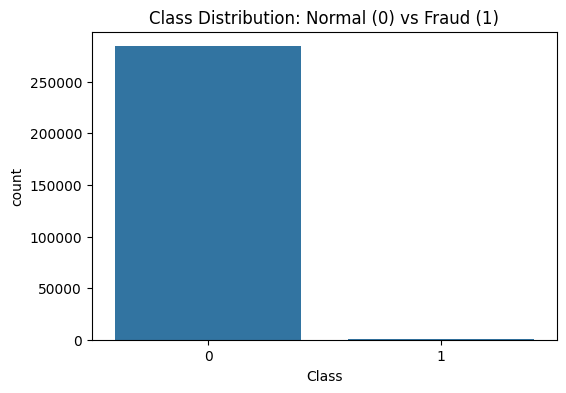

In [17]:
# Check class distribution (Fraud vs Normal)
print(df['Class'].value_counts())

# Visualize class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution: Normal (0) vs Fraud (1)')
plt.show()


### 4. Data Preprocessing
Check for missing values

Scale 'Amount' and 'Time' columns (others are already PCA components)

Separate features and labels

In [18]:
print(df.isnull().sum())  # Should be zero

# Scale 'Amount' and 'Time' because other features are PCA transformed
scaler = StandardScaler()
df['Amount_Scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_Scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop original 'Amount' and 'Time'
df.drop(['Amount','Time'], axis=1, inplace=True)

# Prepare features and labels
X = df.drop('Class', axis=1)
y = df['Class']


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


### 5. Train/Test Split (Stratified)

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")


Train shape: (227845, 30), Test shape: (56962, 30)
Train class distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test class distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


### 6. Baseline Metrics on Unsupervised Anomaly Detection
We will try two common methods:

Isolation Forest

Local Outlier Factor (LOF)

In [20]:
# Isolation Forest Model


iso_forest = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42, verbose=1)
iso_forest.fit(X_train)

# Predict anomaly: -1 means anomaly, 1 means normal
y_pred_train = iso_forest.predict(X_train)
y_pred_test = iso_forest.predict(X_test)

# Convert to binary 0 (normal) and 1 (fraud)
y_pred_test = np.where(y_pred_test == -1, 1, 0)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.33      0.32        98

    accuracy                           1.00     56962
   macro avg       0.65      0.66      0.66     56962
weighted avg       1.00      1.00      1.00     56962



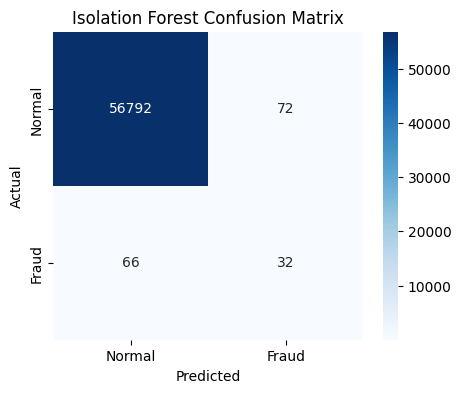

In [21]:
# Evaluation: Isolation Forest

from sklearn.metrics import classification_report, confusion_matrix

print("Isolation Forest Classification Report:")
print(classification_report(y_test, y_pred_test))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Isolation Forest Confusion Matrix')
plt.show()


In [23]:
#  Local Outlier Factor Model

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017, novelty=True)
lof.fit(X_train)

y_pred_lof = lof.predict(X_test)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)


c:\Users\yadav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


# Evaluation: Local Outlier Factor

Local Outlier Factor Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



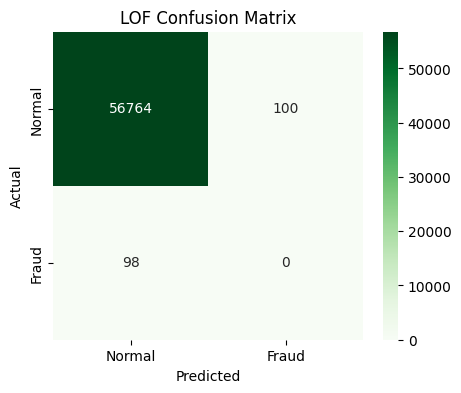

In [24]:
print("Local Outlier Factor Classification Report:")
print(classification_report(y_test, y_pred_lof))

# Confusion matrix plot
cm_lof = confusion_matrix(y_test, y_pred_lof)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lof, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LOF Confusion Matrix')
plt.show()


### ROC Curve Visualization for Both Models

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
c:\Users\yadav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


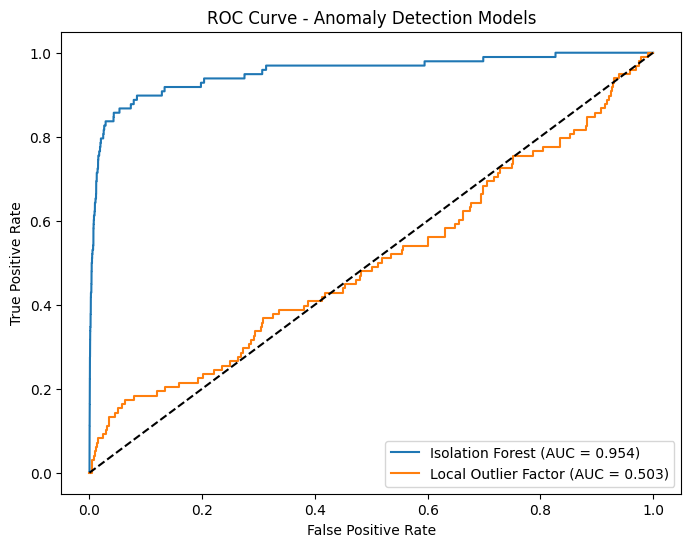

In [25]:
# Isolation Forest anomaly scores (negative outlier factor)
y_scores_if = -iso_forest.decision_function(X_test)

# LOF scores
y_scores_lof = -lof.decision_function(X_test)

fpr_if, tpr_if, _ = roc_curve(y_test, y_scores_if)
fpr_lof, tpr_lof, _ = roc_curve(y_test, y_scores_lof)

plt.figure(figsize=(8,6))
plt.plot(fpr_if, tpr_if, label='Isolation Forest (AUC = {:.3f})'.format(roc_auc_score(y_test, y_scores_if)))
plt.plot(fpr_lof, tpr_lof, label='Local Outlier Factor (AUC = {:.3f})'.format(roc_auc_score(y_test, y_scores_lof)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Anomaly Detection Models')
plt.legend()
plt.show()
